In [2]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 692.14 GB


In [3]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os
from deepgo.utils import Ontology


In [4]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [5]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [6]:
tokenizer.get_vocab_size()


544998

In [7]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [9]:
import json
with open("/home/toibazd/Most_frequent_IPs.json", "r") as f:
    ips = json.load(f)

sorted_dict = sorted(ips.items(), key=lambda x: x[1], reverse=True)
most_frequent_ips = [item[0] for item in sorted_dict[:100]]


In [10]:
print(most_frequent_ips[:10])

['IPR004090', 'IPR011701', 'IPR002514', 'IPR003719', 'IPR002155', 'IPR005750', 'IPR001001', 'IPR004604', 'IPR011603', 'IPR005252']


In [182]:
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import csv
from tqdm.auto import tqdm
import numpy as np



ip_to_go = defaultdict(list)
data_dict = defaultdict(list)
enc = MultiLabelBinarizer()
new_tsv_filename = "/home/toibazd/Family_IPs_with_GO.tsv"
go = Ontology('data/go.obo')


with open(new_tsv_filename, "r") as new_tsvfile:
    reader = csv.reader(new_tsvfile, delimiter="\t")
    next(reader)
    for row in tqdm(reader):
        ip = row[0]  # Assuming the IP is in the first column
        go_terms = row[6]  # Assuming the GO terms are in the second column

        # Add IP and corresponding GO terms to data_dict
        ip_to_go[ip] = go_terms.split(',')


with open("/home/toibazd/Prot2IP_GO_filtered_MF.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])
        
        # Filter InterPro IDs that are in the words list
#         filtered_iprs = [ipr for ipr in iprs if ipr in most_frequent_ips]
        filtered_iprs = iprs
        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in most_frequent_ips:
                for GO in ip_to_go[ip]:
                    data_dict[key].extend(list(GO))
#                     data_dict[key].extend(list(go.get_ancestors(GO)))

one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

21791


In [183]:
len(one_hot_encoded_dict)

21791

In [184]:
len(one_hot_encoded)

21791

In [185]:
# Find unique numbers and their counts
unique_numbers, counts = np.unique(one_hot_encoded, return_counts=True)
all_count = 0
# Print the count of each number
for number, count in zip(unique_numbers, counts):
    all_count+=count
    print(f"Number {number}: Count {count}")
print(all_count)

Number 0: Count 72590
Number 1: Count 210693
283283


In [186]:
import json
with open('BERT_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [187]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

100

In [188]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

100

In [189]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

20155

In [190]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [192]:
print(one_hot_encoded[1])

[1 0 1 0 0 1 0 1 1 0 1 1 1]


In [152]:
batch_size = 128 # Define your batch size

embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]
#     relevant_hidden_states = torch.mean(hidden_states[:, 1:-1, :], dim=1)

    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


  0%|          | 0/40 [00:00<?, ?it/s]

In [153]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts) 

In [154]:
pos_weights

tensor([26., 36., 98.,  3., 63., 60., 53., 48.,  0.,  4.,  4., 43., 95., 97.,
        36.,  0., 95., 98., 89., 48., 32., 98., 48., 48., 48., 48., 97., 97.,
        60., 98., 52., 46., 98., 98., 98., 78., 52., 43., 20., 26., 38., 38.,
        97., 28., 22., 22., 22., 53., 97., 89., 25., 93., 93., 97., 19., 36.,
         2., 80., 80., 95., 42., 80., 80., 69.,  1., 48.,  4., 31.,  1., 98.,
        36., 25., 60., 98., 22., 95., 10., 48., 22.,  2., 15., 15., 53., 53.,
         4., 14., 89., 32., 97., 13., 86., 11., 25., 48., 97., 63., 26., 47.,
        36., 93., 93., 32., 36., 13., 57., 98., 57., 57., 15., 97., 97., 97.,
         2., 13., 52., 17., 17., 36.,  9., 11.,  1.,  3., 15., 15., 80., 69.,
        26., 80., 19., 13., 13., 32., 19., 97., 22., 97.,  0.,  0., 27., 63.,
        98., 63., 98., 32., 98., 98., 98., 98., 98., 98., 20., 83., 97., 95.,
        88., 42., 98., 63., 36., 97., 63., 22., 71., 86., 18., 14., 86.,  4.,
        12., 97., 98., 98., 28., 57., 98., 57., 95., 22., 13., 5

In [155]:
len(embeddings)

5000

In [156]:
len(labels)

5000

In [157]:
import random


# Zip the lists together
combined = list(zip(embeddings, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list
embeddings, labels = zip(*combined)



In [158]:
model.to("cpu")
torch.cuda.empty_cache()

In [159]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 546
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [160]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels

# Define optimizer and loss function
optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [161]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        batch_labels_tensor = batch_labels_tensor.squeeze()

        
        outputs = clf_model(batch_embeddings_tensor)

        
        loss = criterion(outputs, batch_labels_tensor)

        
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")


Epoch 1/20:


Training Batches: 0it [00:00, ?it/s]

1.3121890380859376
Epoch 2/20:


Training Batches: 0it [00:00, ?it/s]

1.1959642059326172
Epoch 3/20:


Training Batches: 0it [00:00, ?it/s]

1.0968857772827147
Epoch 4/20:


Training Batches: 0it [00:00, ?it/s]

1.0474103073120118
Epoch 5/20:


Training Batches: 0it [00:00, ?it/s]

0.9993632400512695
Epoch 6/20:


Training Batches: 0it [00:00, ?it/s]

0.9455679855346679
Epoch 7/20:


Training Batches: 0it [00:00, ?it/s]

0.9015768463134766
Epoch 8/20:


Training Batches: 0it [00:00, ?it/s]

0.8561732803344727
Epoch 9/20:


Training Batches: 0it [00:00, ?it/s]

0.8191336502075195
Epoch 10/20:


Training Batches: 0it [00:00, ?it/s]

0.7900764724731445
Epoch 11/20:


Training Batches: 0it [00:00, ?it/s]

0.7697283966064453
Epoch 12/20:


Training Batches: 0it [00:00, ?it/s]

0.7600112854003906
Epoch 13/20:


Training Batches: 0it [00:00, ?it/s]

0.7631593139648437
Epoch 14/20:


Training Batches: 0it [00:00, ?it/s]

0.7577664962768554
Epoch 15/20:


Training Batches: 0it [00:00, ?it/s]

0.7568113571166992
Epoch 16/20:


Training Batches: 0it [00:00, ?it/s]

0.7551191360473632
Epoch 17/20:


Training Batches: 0it [00:00, ?it/s]

0.7539137634277344
Epoch 18/20:


Training Batches: 0it [00:00, ?it/s]

0.7533470809936523
Epoch 19/20:


Training Batches: 0it [00:00, ?it/s]

0.7519870681762695
Epoch 20/20:


Training Batches: 0it [00:00, ?it/s]

0.7474320556640625
Training finished.


In [162]:
with open('BERT_DNN_senteces_test.json', "r") as f:
    test_sentences = json.load(f)

In [163]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

100

In [164]:
matching_string = test_sentences.values()
len(matching_string)

100

In [165]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

5000

In [166]:
batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]
#     relevant_hidden_states = torch.mean(hidden_states[:, 1:-1, :], dim=1)
    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/40 [00:00<?, ?it/s]

In [167]:
model.to("cpu")
torch.cuda.empty_cache()

In [168]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=546, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [169]:
generator = data_generator(test_embeddings, test_labels, batch_size)
# Iterate over batches
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []
# Initialize lists to store predictions and labels across all batches
# Iterate over batches
count = 0
for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.7).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [170]:
len(all_predictions)

40

In [171]:
len(all_labels[0])
    

128

In [172]:
print(all_predictions[0].shape)

(128, 546)


In [173]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [174]:
all_labels.shape

(5000, 546)

In [175]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.8028767263704124


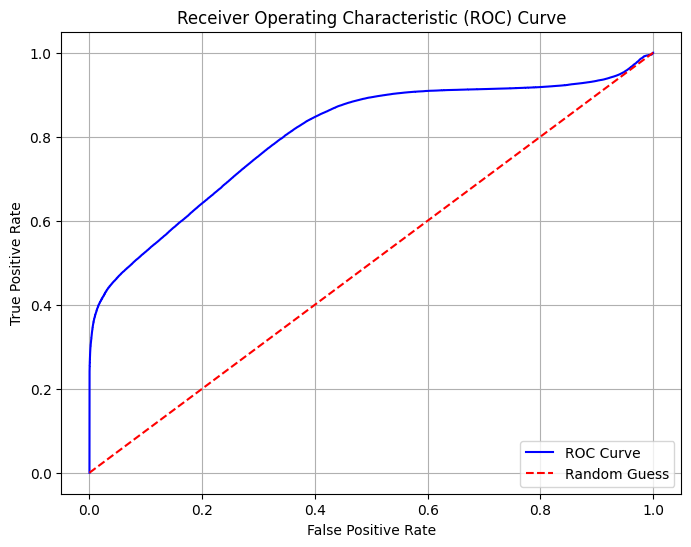

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [177]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
546


In [178]:
cl_report[0]

array([[4528,  288],
       [ 102,   82]])

In [179]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [180]:
all_predictions.sum(axis=0)

array([3.700e+02, 2.580e+02, 1.590e+02, 3.240e+02, 1.570e+02, 1.790e+02,
       1.360e+02, 2.130e+02, 4.002e+03, 2.540e+02, 2.590e+02, 1.540e+02,
       1.490e+02, 4.000e+01, 2.460e+02, 0.000e+00, 2.030e+02, 1.260e+02,
       1.320e+02, 2.140e+02, 9.300e+01, 8.100e+01, 3.440e+02, 1.650e+02,
       2.580e+02, 3.030e+02, 1.990e+02, 2.090e+02, 1.500e+02, 2.260e+02,
       1.810e+02, 2.500e+02, 0.000e+00, 6.800e+01, 0.000e+00, 1.020e+02,
       1.500e+02, 7.700e+01, 1.440e+02, 1.680e+02, 3.470e+02, 1.900e+02,
       7.500e+01, 1.300e+01, 2.140e+02, 2.150e+02, 2.150e+02, 1.360e+02,
       1.810e+02, 3.500e+01, 1.920e+02, 9.600e+01, 1.850e+02, 1.220e+02,
       2.060e+02, 2.550e+02, 9.400e+01, 1.620e+02, 1.590e+02, 1.120e+02,
       2.380e+02, 1.630e+02, 1.620e+02, 1.830e+02, 2.790e+02, 9.800e+01,
       3.230e+02, 2.930e+02, 2.460e+02, 1.750e+02, 2.450e+02, 5.800e+01,
       1.270e+02, 2.410e+02, 2.130e+02, 1.640e+02, 4.450e+02, 1.960e+02,
       2.140e+02, 3.880e+02, 3.350e+02, 3.330e+02, 

In [181]:
print(report)

              precision    recall  f1-score   support

           0       0.22      0.45      0.30       184
           1       0.35      0.67      0.46       135
           2       0.30      0.96      0.46        50
           3       0.83      0.27      0.41      1008
           4       0.35      0.71      0.47        77
           5       0.21      0.47      0.29        81
           6       0.35      0.52      0.42        92
           7       0.45      0.95      0.61       100
           8       1.00      0.80      0.89      5000
           9       0.89      0.25      0.39       907
          10       0.87      0.25      0.39       907
          11       0.18      0.25      0.21       113
          12       0.01      0.04      0.02        52
          13       0.03      0.02      0.02        51
          14       0.35      0.65      0.46       133
          15        nan      0.00      0.00      3414
          16       0.14      0.54      0.22        52
          17       0.38    

In [107]:
enc.classes_[1]

'GO:0000096'